In [0]:
import numpy as np
import pandas as pd
np.random.seed(1)
dataframe = pd.read_csv("https://raw.githubusercontent.com/apoorvajavali/lstm-stock-price-prediction/master/MSFT.csv",index_col='Date')

In [0]:
from sklearn.preprocessing import MinMaxScaler

# Target column
stock_series = dataframe.iloc[:, -2:-1].values

scaler = MinMaxScaler()
stock_series = scaler.fit_transform(stock_series)

time_steps = 5
input_set = []
target_set = []

for i in range(len(stock_series) - time_steps):
  input_set.append(stock_series[i:i+time_steps, 0])
  target_set.append(stock_series[i+1:i+time_steps+1, 0])

input_set, target_set = np.array(input_set), np.array(target_set)

input_len = len(input_set)
train = int(0.6 * input_len)
val = int(0.2 * input_len)
test = int(0.2 * input_len)


training_set = {"inputs":input_set[:train], "targets":target_set[:train]}
validation_set = {"inputs":input_set[train:train+val], "targets":target_set[train:train+val]}
test_set = {"inputs":input_set[-test:], "targets":target_set[-test:]}

In [0]:
def initializeLSTM(hidden_size, input_size, output_size):
  
  total_input = hidden_size + input_size

  # Forget gate: weights and bias
  Weight_forget = np.random.random((hidden_size, total_input))
  bias_forget = np.zeros((hidden_size, 1))

  # Input gate: weights and bias
  Weight_input = np.random.random((hidden_size, total_input))
  bias_input = np.zeros((hidden_size, 1))

  # Candidate gate: weights and bias
  Weight_candidate = np.random.random((hidden_size, total_input))
  bias_candidate = np.zeros((hidden_size, 1))

  # Output gate: weights and bias
  Weight_output = np.random.random((hidden_size, total_input))
  bias_output = np.zeros((hidden_size, 1))

  # Final layer hidden to output
  Weight_v = np.random.random((output_size, hidden_size))
  bias_v = np.zeros((output_size, 1))

  return Weight_forget, Weight_input, Weight_candidate, Weight_output, Weight_v, bias_forget, bias_input, bias_candidate, bias_output, bias_v

hidden_size = 21
input_size = 1
output_size = time_steps

parameters = initializeLSTM(hidden_size, input_size, output_size)


In [0]:
def sigmoid(x):
  x = x + 1e-12
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  return x * (1 - x)

def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def tanh_derivative(x):
  return 1 - (x ** 2)

In [0]:
def forward_pass(inputs, h_prev, C_prev, params):

  Weight_forget, Weight_input, Weight_candidate, Weight_output, Weight_v, bias_forget, bias_input, bias_candidate, bias_output, bias_v = params

  # Save a list of computations for each of the components in the LSTM
  combined_s, forget_s, input_s,  = [], [] ,[]
  candidate_s, Cell_s, out_s, hidden_s = [], [] ,[], []
  v_s, output_s =  [], [] 
    
  # Append the initial cell and hidden state to their respective lists
  hidden_s.append(h_prev)
  Cell_s.append(C_prev)

  inputs = np.array(inputs).reshape(len(inputs) ,1)
  
  for value in inputs:

    combined = np.row_stack((h_prev, value))
    combined_s.append(combined)

    # Calculate forget gate 
    forget = sigmoid(np.dot(Weight_forget, combined) + bias_forget)
    forget_s.append(forget)

    # Calculate input gate
    i = sigmoid(np.dot(Weight_input, combined) + bias_input) 
    input_s.append(i)

    # Calculate candidate gate
    candidate = tanh(np.dot(Weight_candidate, combined) + bias_candidate)
    candidate_s.append(candidate)

    # Update cell state
    C_prev = forget * C_prev + i * candidate
    Cell_s.append(C_prev)

    # Calculate output gate
    out = sigmoid(np.dot(Weight_output, combined) + bias_output)
    out_s.append(out)

    # Update hidden state
    h_prev = out * tanh(C_prev)
    hidden_s.append(h_prev)

    # Calculate final output
    v = np.dot(Weight_v, h_prev) + bias_v
    v_s.append(v)

    output = tanh(v)
    output_s.append(output)

  return combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s


In [0]:
def clip_gradient_norm(gradients, maximum_norm=0.25):
  
    maximum_norm = float(maximum_norm)
    total_norm = 0

    for gradient in gradients:
        gradient_norm = np.sum(np.power(gradient, 2))
        total_norm += gradient_norm
    
    total_norm = np.sqrt(total_norm)

    clip_coefficient = maximum_norm / (total_norm + 1e-6)

    if clip_coefficient < 1:
        for gradient in gradients:
            gradient *= clip_coefficient
    
    return gradients

In [0]:
def backward_pass(combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s, target, parameters):
  
  Weight_forget, Weight_input, Weight_candidate, Weight_output, Weight_v, bias_forget, bias_input, bias_candidate, bias_output, bias_v = parameters
  
  Weight_forget_derivative = np.zeros_like(Weight_forget)
  bias_forget_derivative = np.zeros_like(bias_forget)

  Weight_input_derivative = np.zeros_like(Weight_input)
  bias_input_derivative = np.zeros_like(bias_input)

  Weight_candidate_derivative = np.zeros_like(Weight_candidate)
  bias_candidate_derivative = np.zeros_like(bias_candidate)

  Weight_output_derivative = np.zeros_like(Weight_output)
  bias_output_derivative = np.zeros_like(bias_output)

  Weight_v_derivative = np.zeros_like(Weight_v)
  bias_v_derivative = np.zeros_like(bias_v)

  der_next_h = np.zeros_like(hidden_s[0])
  der_next_C = np.zeros_like(Cell_s[0])

  loss = 0

  for t in reversed(range(len(output_s))):
    
    loss += (target[t] - output_s[t][0][0]) ** 2

    C_prev= Cell_s[t-1]

    derivative_v = (target[t] - output_s[t]) * tanh_derivative(output_s[t])
  
    Weight_v_derivative += np.dot(derivative_v, hidden_s[t].T)
    bias_v_derivative += derivative_v

    derivative_h = np.dot(Weight_v.T, derivative_v) 
    derivative_h += der_next_h
    
    derivative_o = derivative_h * tanh(Cell_s[t])
    derivative_o = sigmoid_derivative(out_s[t])*derivative_o
    Weight_output_derivative += np.dot(derivative_o, combined_s[t].T)
    bias_output_derivative += derivative_o

    derivative_C = np.copy(der_next_C)
    derivative_C += derivative_h * out_s[t] * tanh_derivative(tanh(Cell_s[t]))
    
    derivative_c = derivative_C * input_s[t]
    derivative_c = tanh_derivative(candidate_s[t]) * derivative_c
    Weight_candidate_derivative += np.dot(derivative_c, combined_s[t].T)
    bias_candidate_derivative += derivative_c

    derivative_i = derivative_C * C_prev
    derivative_i = sigmoid_derivative(input_s[t]) * derivative_i 
    Weight_input_derivative += np.dot(derivative_i, combined_s[t].T)
    bias_input_derivative += derivative_i

    gradients = Weight_forget_derivative, Weight_input_derivative, Weight_candidate_derivative, Weight_output_derivative, Weight_v_derivative, bias_forget_derivative, bias_input_derivative, bias_candidate_derivative, bias_output_derivative, bias_v_derivative

    gradients = clip_gradient_norm(gradients)

  return loss, gradients

In [0]:
def update_weights(parameters, gradients, learning_rate):
    for parameter, gradient in zip(parameters, gradients):
        parameter += learning_rate * gradient   
    return parameters

Epoch 0 ============== training loss: 320.36554968120424, validation loss: 63.933814927648804
Epoch 10 ============== training loss: 9.388775451479804, validation loss: 0.19169623921306944
Epoch 20 ============== training loss: 1.8538051183875006, validation loss: 0.11467381365433423
Epoch 30 ============== training loss: 0.6799677506539443, validation loss: 0.14513702039128784
Epoch 40 ============== training loss: 0.2706818617204493, validation loss: 0.15454028255528635
Epoch 50 ============== training loss: 0.22386647487697953, validation loss: 0.14942322723833734
Epoch 60 ============== training loss: 0.2292961850761108, validation loss: 0.1412600564902426
Epoch 70 ============== training loss: 0.23227861634431934, validation loss: 0.13370534175102827
Epoch 80 ============== training loss: 0.22603869037253393, validation loss: 0.12873384951477684
Epoch 90 ============== training loss: 0.2150094625856665, validation loss: 0.12588427550027512
Epoch 99 ============== training loss: 0.

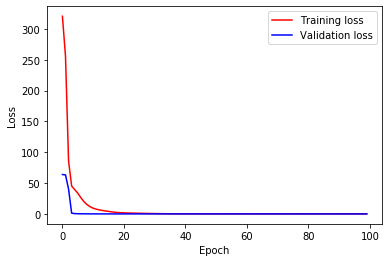

In [389]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = 100

train_loss = []
val_loss = []

for t in range(epochs):
  
    epoch_train_loss = 0
    epoch_val_loss = 0

    for n in range(len(validation_set['inputs'])):

      inputs = validation_set['inputs'][n]
      target = validation_set['targets'][n]

      h = np.zeros((hidden_size, 1))
      c = np.zeros((hidden_size, 1))
     
      combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s = forward_pass(inputs, h, c, parameters)
     
      loss, gradients = backward_pass(combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s, target, parameters)
  
      parameters = update_weights(parameters, gradients, 0.1)

      epoch_val_loss += loss
   
    for n in range(len(training_set['inputs'])):

      inputs = training_set['inputs'][n]
      target = training_set['targets'][n]

      h = np.zeros((hidden_size, 1))
      c = np.zeros((hidden_size, 1))

      combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s = forward_pass(inputs, h, c, parameters)

      loss, gradients = backward_pass(combined_s, forget_s, input_s, candidate_s, Cell_s, out_s, hidden_s, v_s, output_s, target, parameters)
      
      parameters = update_weights(parameters, gradients, 0.1)
      
      epoch_train_loss += loss
         
    train_loss.append(epoch_train_loss/len(training_set))
    val_loss.append(epoch_val_loss/len(validation_set))

    if t % 10 == 0 or t == epochs - 1:
      print(f'Epoch {t} ============== training loss: {train_loss[-1]}, validation loss: {val_loss[-1]}')


# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()


Actual Stock:
[122.47758499999999, 124.14018200000001, 123.71463, 127.811722, 128.544052, 128.425308, 129.24671899999998, 126.55488600000001, 124.902199, 127.56430099999999, 126.822083, 124.21933700000001, 124.20945, 124.199554, 125.81266000000001, 122.071831, 123.43753799999999, 125.17580400000001, 128.066315, 127.212082, 125.37447399999998, 126.04991899999997, 126.81475800000001, 125.33474, 125.39433300000002, 125.31488, 124.103043, 124.88775600000002, 122.85148600000001, 119.037209, 122.33496899999999, 124.98709099999998, 126.963753, 130.51976000000002, 131.71173100000001, 131.21508799999998, 130.609177, 131.43360900000002, 131.56274399999998, 131.960068, 134.254578, 134.781021, 136.032578, 136.05246, 136.857025, 132.536163, 133.032822, 133.251343, 133.062622, 134.771103, 135.665085, 136.539185, 136.141846, 136.042526, 135.545883, 136.926559, 137.47287, 137.969528, 137.969528, 136.161728, 135.35716200000002, 135.506134, 135.704803, 137.50267, 138.35690300000002, 139.777344, 139.2508

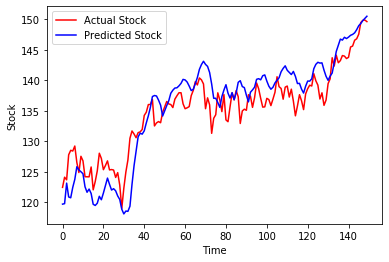

In [390]:
test_inputs, test_targets = test_set['inputs'], test_set['targets']

# Initialize hidden state and cell state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))
# Forward pass
z, f, i, c, C_prev, o, h_prev, v, output = forward_pass(test_inputs[0], h, c, parameters)
predicted = [scaler.inverse_transform([x]) for x in output[-1]]
predicted_stocks = [p[0][0] for p in predicted]

for n in range(1, len(test_inputs)):
  # Initialize hidden state and cell state as zeros
  h = np.zeros((hidden_size, 1))
  c = np.zeros((hidden_size, 1))
  
  # Forward pass
  z, f, i, c, C_prev, o, h_prev, v, output = forward_pass(test_inputs[n], h, c, parameters)

  predicted = [scaler.inverse_transform([x]) for x in output[-1]]
  out_stock = np.array([p[0][0] for p in predicted])
  predicted_stocks.append(out_stock[-1])

stocks = scaler.inverse_transform(stock_series)
actual_stocks = []
for i in range(train+val, train+val+test):
  actual_stocks.append(stocks[i][0])

print("Actual Stock:")
print(actual_stocks)
print("Predicted Stock:")
print(predicted_stocks)

# Plot training and validation loss
time = np.arange(len(test_inputs))

error = 0
for i in range(len(time)):
  error += (actual_stocks[i] - predicted_stocks[i]) ** 2
error = error/len(time)
print("Mean squared error on test set:")
print(error)


plt.figure()
plt.plot(time, actual_stocks[:len(time)], 'r', label='Actual Stock')
plt.plot(time, predicted_stocks[:len(time)], 'b', label='Predicted Stock')
plt.legend()
plt.xlabel('Time'), plt.ylabel('Stock')
plt.show()